# Analysis combined of different algorithms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [3]:
# load numpy arrays from files
devrl_returns = np.load('DevRL/BG_NOISE/overall_returns.npy')
devrl_params = np.load('DevRL/BG_NOISE/parameter_values.npy')

dual_pathway_returns = np.load('Dual_Pathway/BG_NOISE/overall_returns.npy')
dual_pathway_params = np.load('Dual_Pathway/BG_NOISE/parameter_values.npy') 

stdrl_returns = np.load('std_RL/BG_NOISE/overall_returns.npy')
stdrl_params = np.load('std_RL/BG_NOISE/parameter_values.npy')

simannealing_returns = np.load('Sim_Annealing/NOISE/overall_returns_1.npy')
simannealing_params = np.load('Sim_Annealing/NOISE/parameter_values_1.npy')


In [4]:
def plot_results(returns, params, label):
    returns = np.array(returns) * 100
    sorted_params = sorted(params)
    # print(sorted_params)    
    sorted_indices = np.argsort(params)

    returns = returns[:,sorted_indices]
    above_threshold = np.zeros(len(params))
    for i in range(len(params)):
        above_threshold[i] = np.sum(returns[:,i] > 70)
    plt.bar(range(len(params)), 100*above_threshold/len(returns), color='blue', alpha=0.5)
    for i in range(len(params)):
        plt.plot(i * np.ones_like(returns[:,i]), returns[:,i], 'o', color='black', markersize=0.5, alpha = 0.2)
        plt.text(i, 100*above_threshold[i]/len(returns), f"{100*above_threshold[i]/len(returns):.1f}%", ha='center', va='bottom')
    plt.xlabel('Parameter set')        
    plt.hlines(70, 0, len(params), colors='r', linestyles='dashed')
    plt.xticks(np.arange(len(params), step=1), labels=sorted_params)
    plt.ylabel('Percentage of runs above 70%')  
    plt.ylim(0, 100)
    plt.title(f"Variability of performance for {label} with noise") 
    plt.legend()    
    plt.show()  






In [67]:
def plot_results_violin(returns, params, label, xlabels=None, title=None):
    returns = np.array(returns) * 100  # Convert to percentage
    sorted_params = sorted(params)
    sorted_indices = np.argsort(params)
    
    returns = returns[:, sorted_indices]
    sorted_params = np.array(params)[sorted_indices]

    n_values = len(sorted_params)
    above_threshold = np.zeros(n_values)
    
    # Flatten data for seaborn
    data = []
    labels = []

    for i in range(n_values):
        col = returns[:, i]/100
        above_threshold[i] = np.sum(col > 0.70) / len(col)
        data.extend(col)
        labels.extend([sorted_params[i]] * len(col))

    # Plotting
    plt.figure(figsize=(3 * n_values, 6))

    # Create a violin plot
    ax = sns.violinplot(x=labels, y=data, inner='quartile', color='darkslateblue', fill=False, alpha=1, 
                        split=False, inner_kws={'linewidth': 1, 'color': 'darkslateblue', 'alpha': 1})

    # Add scatter plot over violin plot
    sns.stripplot(x=labels, y=data, size=2, color='black', alpha=0.2, jitter=0.2)

    # Add threshold line
    plt.axhline(0.70, 0.05, 0.95, color='red', linestyle='--', label='Global maxima threshold')

    # Add percentage annotations
    for i in range(n_values):
        plt.text(i+0.25, 0.73, f"{100 * above_threshold[i]:.0f}%", ha='center', va='bottom', fontsize=14, color='red')

    # Set labels and limits
    plt.xlabel(label, fontsize=16)
    plt.ylabel('Final Performance', fontsize=16)
    plt.ylim(0, 1)
    plt.suptitle(title, fontsize=20)

    # Remove top and right spines for cleaner look
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)    

    # Handle x-ticks dynamically
    if xlabels is not None:
        plt.xticks(ticks=range(n_values), labels=xlabels, fontsize=14)

    plt.legend(loc ='lower right', fontsize=16)
    plt.tight_layout()
    plt.show()


In [41]:
simannealing_returns.shape, simannealing_params.shape

((100, 7), (7,))

In [57]:
simannealing_params[np.argsort(simannealing_params)]

array([0.001, 0.005, 0.01 , 0.05 , 0.1  , 0.2  , 0.5  ])

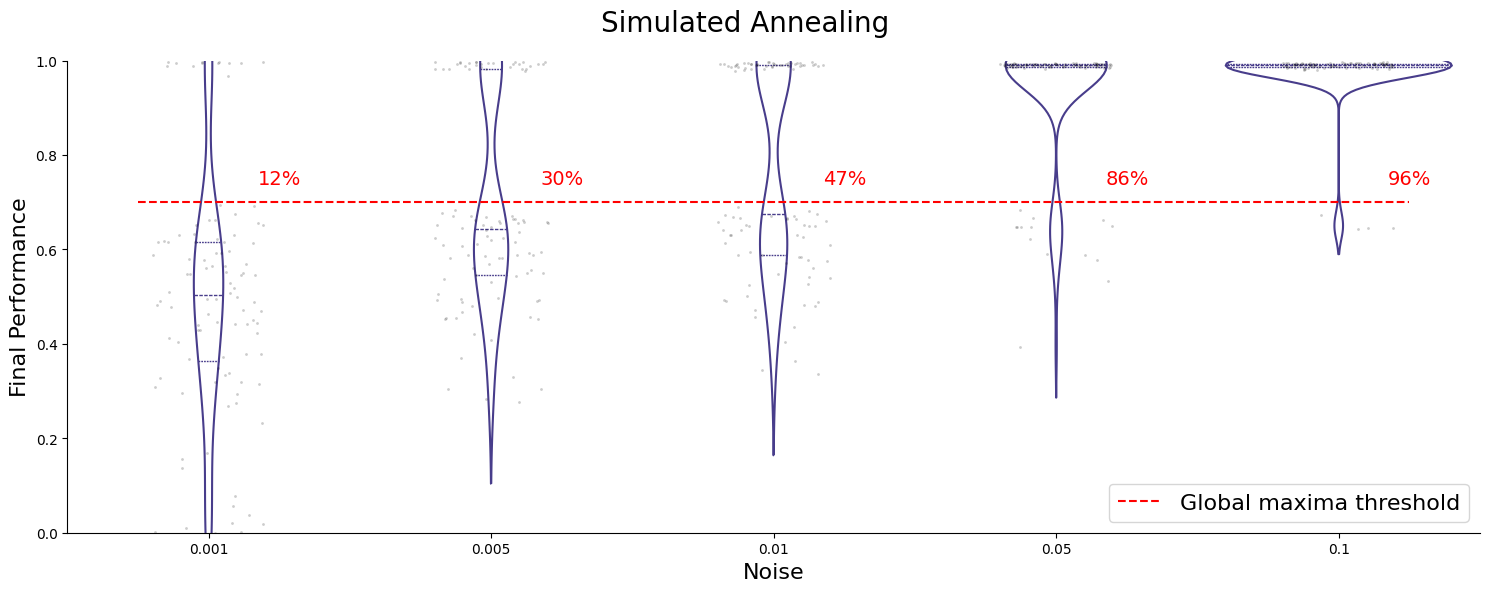

In [68]:
plot_results_violin(simannealing_returns[:,np.argsort(simannealing_params)[:5]], simannealing_params[np.argsort(simannealing_params)[:5]], 'Noise', title='Simulated Annealing')  

In [17]:
print(np.min(simannealing_returns))
print(np.max(simannealing_returns))
print(np.mean(simannealing_returns))
print(np.std(simannealing_returns))

9.407692286469075e-05
0.9999698391039861
0.8368621474122246
0.23743963483715994


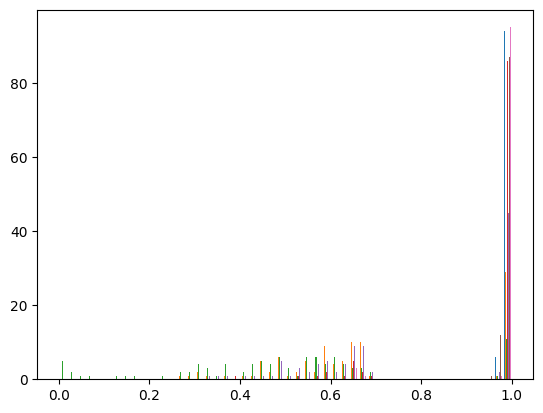

In [19]:
plt.hist(simannealing_returns, bins=50)
plt.show()

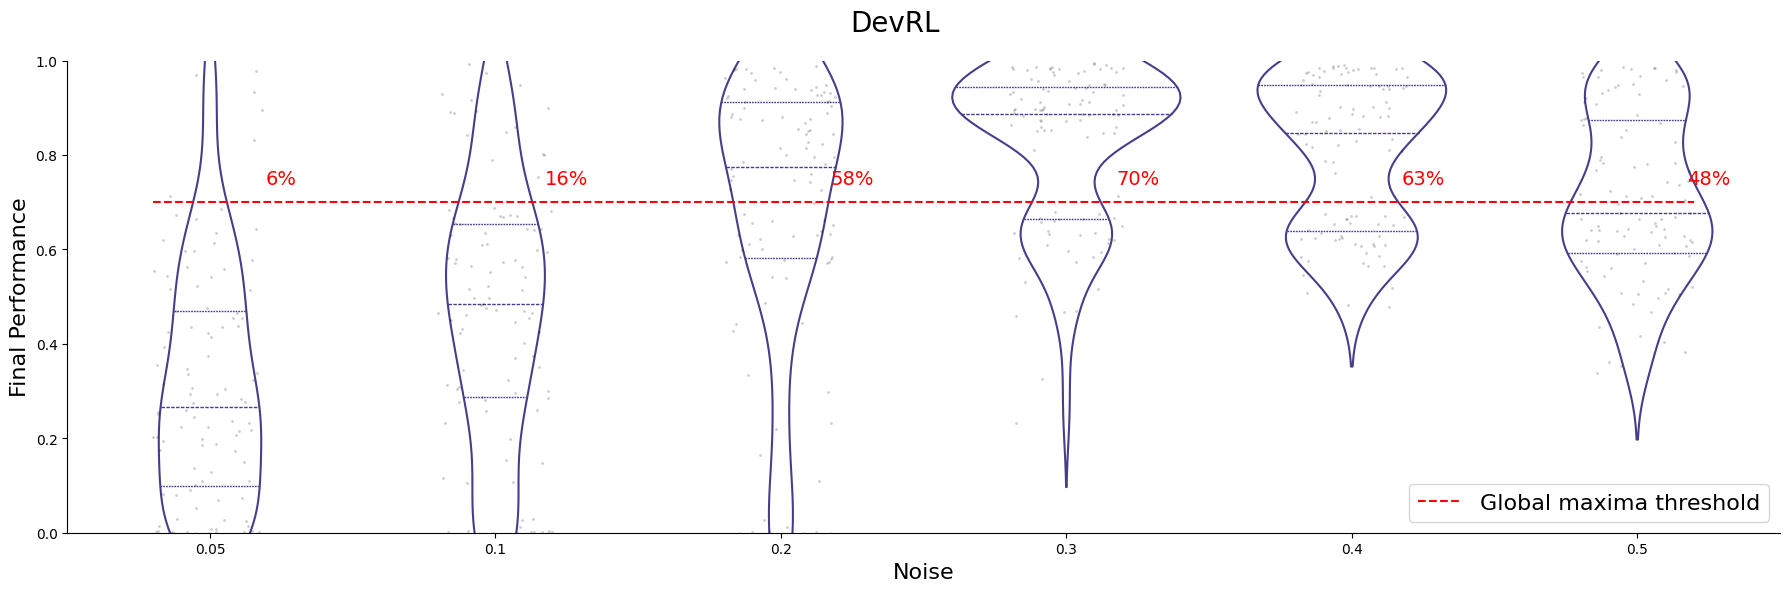

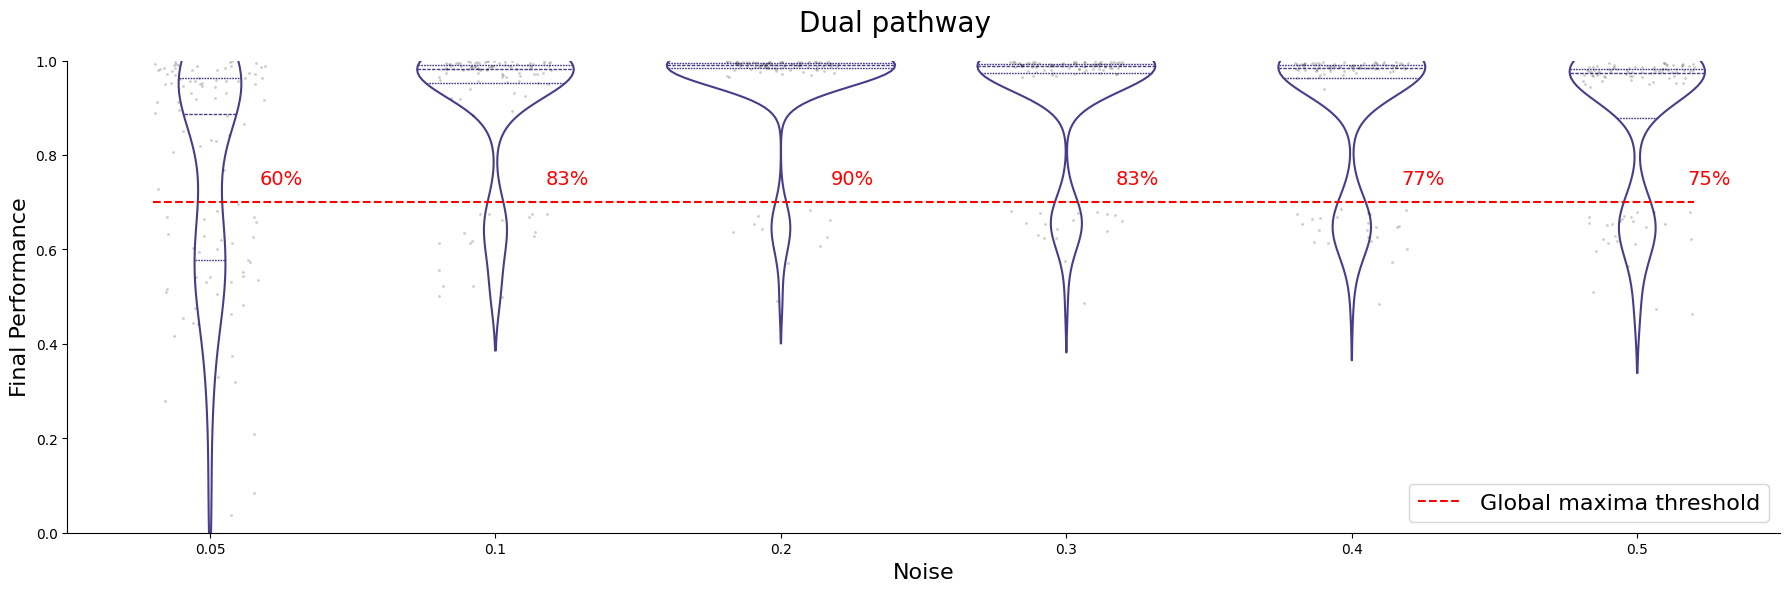

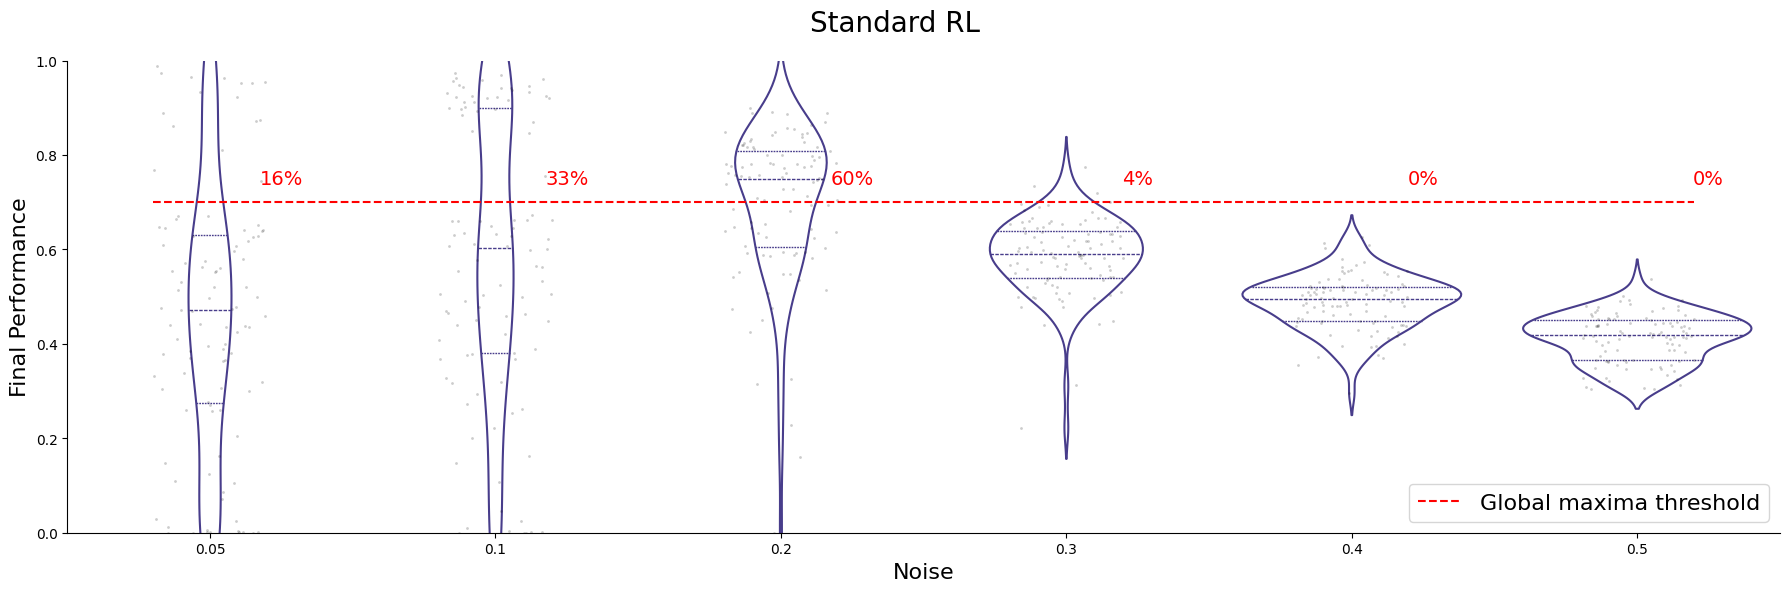

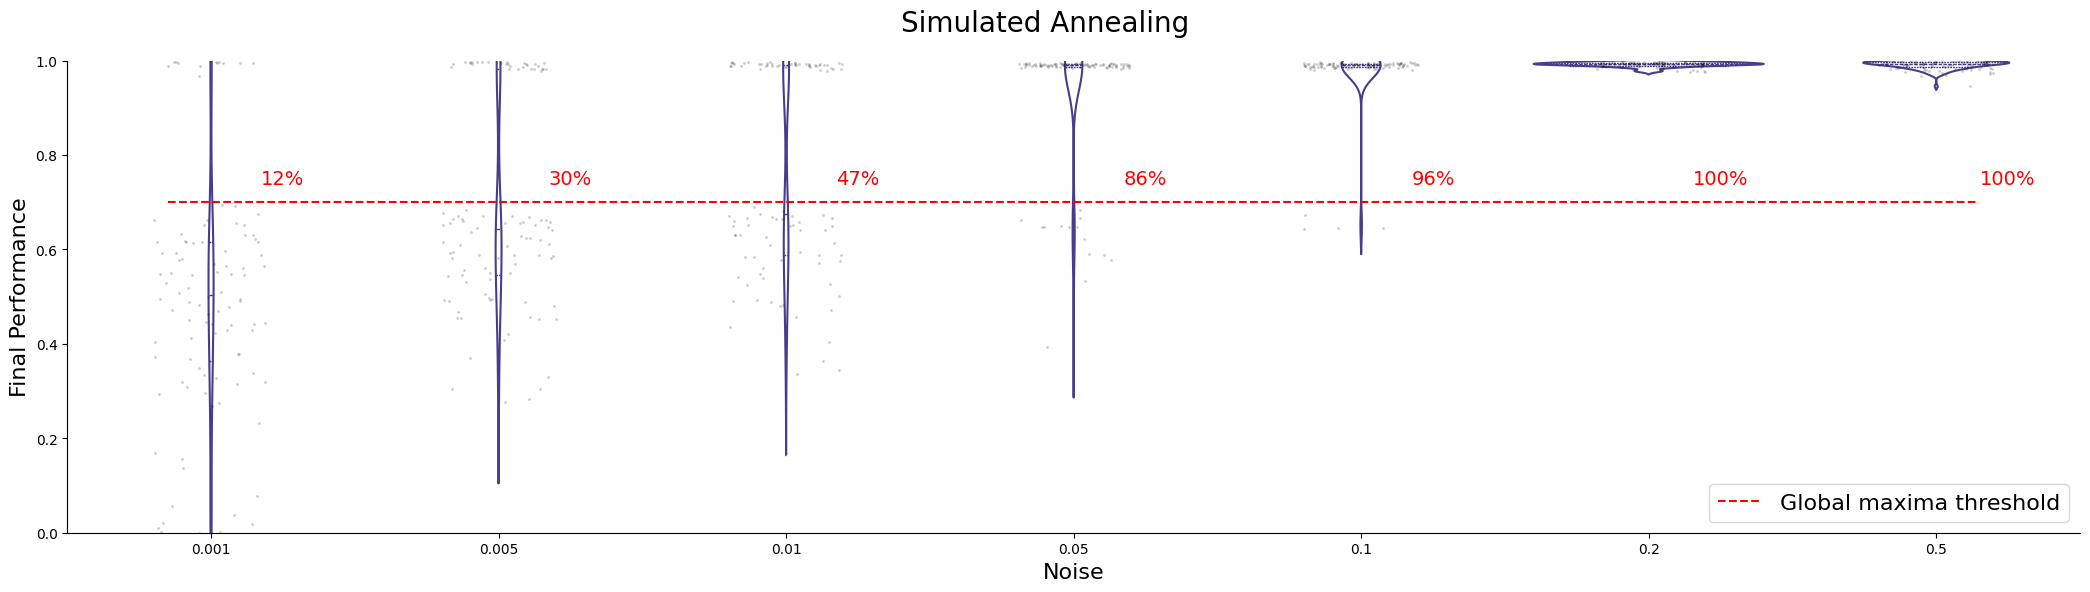

In [69]:
plot_results_violin(devrl_returns, devrl_params, 'Noise', title='DevRL')  
plot_results_violin(dual_pathway_returns, dual_pathway_params,'Noise', title= 'Dual pathway')
plot_results_violin(stdrl_returns, stdrl_params, 'Noise', title='Standard RL')
plot_results_violin(simannealing_returns, simannealing_params,'Noise', title= 'Simulated Annealing')    